## 1.1 Beelden

*  dataset (MIT-license):
https://public.roboflow.com/object-detection/self-driving-car/3/download/yolov8
Cars are probably the lines that start with 1
https://public.roboflow.com/object-detection/self-driving-car
*  dataset-overview:
https://www.cityscapes-dataset.com/dataset-overview/
*  onderstaande code gaat uit van 2 folders die deze dataset bevatten: images en labels

In [1]:
#Definiëren van de sample size en de grootte van de uiteindelijke dataset
#dataset is kleiner omdat we de images die trucks bevatten (zoals gedetecteerd via de predict functie uit Yolo) uitzuiveren
sample_size = 10000
total_images_dataset = 3024

In [2]:
import os
#Declareren waar de images en labels van de Cityscapes dataset staan (na upload van deze images en labels naar Google Drive)
source_folder_labels = "./labels"
source_folder_images = "./images"

#Declareren van de folders die in de notebook gebruikt en automatisch aangemaakt worden
sample_folder = "./sampleSize"
sample_folder_size = sample_folder + str(sample_size)
sample_folder_predict = os.path.join(sample_folder_size, "Yolo_output","predict","labels")
sample_folder_size_images = os.path.join(sample_folder_size, "images")
sample_folder_size_labels = os.path.join(sample_folder_size, "labels")
training_sets_folder = os.path.join(sample_folder_size, "training_sets")
bounding_box_folder = os.path.join(sample_folder_size, "images_bounding_boxes")

In [3]:
#tellen aantal beelden in de dataset
import os
all_images = [f for f in os.listdir(source_folder_images)]
print("totaal aantal beelden in de folder geupload in google drive:", len(all_images))
all_labels = [f for f in os.listdir(source_folder_labels)]
print("totaal aantal labels in de folder geupload in google drive:", len(all_labels))

totaal aantal beelden in de folder geupload in google drive: 29800
totaal aantal labels in de folder geupload in google drive: 29800


### 1.1.1 Beelden samplen

In [65]:
#functie definitie
#input: sample_size
#returns 2 folders (labels en images) in de sample_size folder
import os
import random
import shutil

def select_random_txt_files(num_files):
    # Create destination folders if it doesn't exist
    if not os.path.exists(sample_folder_size_images):
        os.makedirs(sample_folder_size_images)
    if not os.path.exists(sample_folder_size_labels):
        os.makedirs(sample_folder_size_labels)

    # Get list of all files in the source image folder
    all_images = [f for f in os.listdir(source_folder_images)]

    # Select random images
    random_images = random.sample(all_images, num_files)

    # Get list of all TXT files in the source folder
    all_txt_files = [f for f in os.listdir(source_folder_labels)]

    # Select random TXT files with the same name as the randomly selected images
    random_txt_files = []
    random_images_files = []
    for image_name in random_images:
        txt_file_with_same_name = [txt for txt in all_txt_files if os.path.splitext(txt)[0] == os.path.splitext(image_name)[0]]
        if txt_file_with_same_name:
            random_txt_files.append(txt_file_with_same_name[0])
            random_images_files.append(image_name)

    # Copy selected TXT files to destination folder
    for txt_file in random_txt_files:
        source_path = os.path.join(source_folder_labels, txt_file)
        dest_path_labels = os.path.join(sample_folder_size_labels, txt_file)
        shutil.copyfile(source_path, dest_path_labels)

    # Copy selected images files to destination folder (last copy fails ==> Bug in Google Drive???)
    for image_file in random_images_files:
        source_path = os.path.join(source_folder_images, image_file)
        dest_path_images = os.path.join(sample_folder_size_images, image_file)
        shutil.copyfile(source_path, dest_path_images)

In [66]:
# Call the function to select and copy random files
select_random_txt_files(sample_size)

In [67]:
#controle op aangemaakte sample
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
all_labels = [f for f in os.listdir(sample_folder_size_labels)]
print("aantal labels in de sample folder:", len(all_labels))

aantal beelden in de sample folder: 10000
aantal labels in de sample folder: 10000


1.1.2 Beelden uitzuiveren

In [ ]:
#elk beeld in de sample verwerken met predict functie van Yolov8 zodat we een label-file hebben
# wegschrijven resultaten in de sample_size folder onder Yolo_output/predict/labels
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image
model = YOLO('yolov8n.pt')
model.names

# inhoud results zie https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.to
if not os.path.exists(sample_folder_predict):
  os.makedirs(sample_folder_predict)
model.predict(source = os.path.join(sample_folder_size, "images"), save_txt = True, exist_ok=True, project=os.path.join(sample_folder_size, "Yolo_output"))

In [4]:
#controle
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print(sample_folder_predict)
print("aantal labels in de predict folder:", len(predict_labels))

./sampleSize10000\Yolo_output\predict\labels
aantal labels in de predict folder: 2864


In [ ]:
#beelden en labels weggooien uit de sampleSize folder als ze geen auto's bevatten
import os
import random

# Get list of all label files in the predict folder
truth_txt_files = [f for f in os.listdir(sample_folder_size_labels)]

# Select random TXT files with the same name as the randomly selected images
labels_containing_cars = []
for label_file in truth_txt_files:
  with open(os.path.join(sample_folder_size_labels, label_file), 'r') as f:
    lines = f.readlines()
    for line in lines:
        class_id, _, _, _, _ = map(float, line.strip().split())
        if class_id == 1:
          labels_containing_cars.append(label_file)
          break

print("aantal beelden met auto's: ", len(labels_containing_cars))

# Remove elements
truth_txt_files_filtered = [file for file in truth_txt_files if file not in labels_containing_cars]
print("aantal beelden zonder auto's: ", len(truth_txt_files_filtered))

for label_file_without_car in truth_txt_files_filtered:
    if os.path.exists(os.path.join(sample_folder_size_labels, label_file_without_car)):
        os.remove(os.path.join(sample_folder_size_labels, label_file_without_car))
    else:
      print("no label file in sample folder")
    if os.path.exists(os.path.join(sample_folder_predict, label_file_without_car)):
        os.remove(os.path.join(sample_folder_predict, label_file_without_car))
    else:
      print("no label file in predict folder")
    image_file = os.path.splitext(label_file_without_car)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
       os.remove(os.path.join(sample_folder_size_images, image_file))
    else:
      print("no image file in sample folder")


#controle op aangemaakte sample
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
all_labels = [f for f in os.listdir(sample_folder_size_labels)]
print("aantal labels in de sample folder:", len(all_labels))
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print("aantal labels in de predict folder:", len(predict_labels))

In [71]:
#beelden weggooien uit de sampleSize folder als ze trucks bevatten volgens Yolov8 en reduceren naar 504 stuks in totaal
import os
import random

# Get list of all label files in the predict folder
predict_txt_files = [f for f in os.listdir(sample_folder_predict)]

# Select random TXT files with the same name as the randomly selected images
labels_containing_trucks = []
for label_file in predict_txt_files:
  with open(os.path.join(sample_folder_predict, label_file), 'r') as f:
    lines = f.readlines()
    for line in lines:
        class_id, _, _, _, _ = map(float, line.strip().split())
        if class_id == 7:
          labels_containing_trucks.append(label_file)
          break

print("aantal beelden met trucks: ", len(labels_containing_trucks))

if len(predict_txt_files) - len(labels_containing_trucks) > total_images_dataset:
  for label_file_with_truck in labels_containing_trucks:
    if os.path.exists(os.path.join(sample_folder_size_labels, label_file_with_truck)):
        os.remove(os.path.join(sample_folder_size_labels, label_file_with_truck))
    else:
      print("no label file in sample folder")
    if os.path.exists(os.path.join(sample_folder_predict, label_file_with_truck)):
        os.remove(os.path.join(sample_folder_predict, label_file_with_truck))
    else:
      print("no label file in predict folder")
    image_file = os.path.splitext(label_file_with_truck)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
       os.remove(os.path.join(sample_folder_size_images, image_file))
    else:
      print("no image file in sample folder")
else:
  print("er zijn niet genoeg files beschikbaar. Selecteer een grotere sample size in 1.1, delete de folder sampleSizeXXX in je drive en laat alles opnieuw draaien")

#resterende files wegdoen zodat we op het aantal stuks uitkomen in de variabele total_images_dataset
all_files = os.listdir(sample_folder_size_labels)
total_files = len(all_files)

if total_files <= total_images_dataset:
   print("geen bestanden te verwijderen. Al minder dan of gelijk aan de total_images_dataset variabele. Selecteer een grotere sample size in 1.1, delete de folder sampleSizeXXX in je drive en laat alles opnieuw draaien")

# Calculate the number of files to delete
files_to_delete_count = total_files - total_images_dataset

# Randomly select files to delete
files_to_delete = random.sample(all_files, files_to_delete_count)

# Remove selected files
for file_name in files_to_delete:
    os.remove(os.path.join(sample_folder_size_labels, file_name))
    image_file = os.path.splitext(file_name)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
      os.remove(os.path.join(sample_folder_size_images, image_file))
    if os.path.exists(os.path.join(sample_folder_predict, file_name)):
      os.remove(os.path.join(sample_folder_predict, file_name))

aantal beelden met trucks:  2824


In [7]:
#controle
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
truth_labels = [f for f in os.listdir(sample_folder_size_labels)]
print(sample_folder_size_labels)
print("aantal labels in de sample folder:", len(truth_labels))
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print("aantal labels in de predict folder:", len(predict_labels))

aantal beelden in de sample folder: 3024
./sampleSize10000\labels
aantal labels in de sample folder: 3024
aantal labels in de predict folder: 2864


In [73]:
# adjusting the truth labels to match the class IDs used by the pretrained YOLO model ==> change ClassId from 1 to 2
# only keeping truth label for cars

import os

print(sample_folder_size_labels)

# Get list of all label files in the predict folder
truth_txt_files = [f for f in os.listdir(sample_folder_size_labels)]

# Function to update class IDs
def update_class_ids(label_file):
    updated_lines = []
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id == 1:
                parts[0] = '2'  # Update class_id from 1 to 2
                updated_lines.append(' '.join(parts) + '\n')

    with open(label_file, 'w') as file:
        file.writelines(updated_lines)

# Process all label files in the directory
for label_file in truth_txt_files:
    file_path = os.path.join(sample_folder_size_labels, label_file)
    update_class_ids(file_path)

./sampleSize10000\labels


1.1.3 Beelden verrijken met bounding boxes

In [14]:
#alle beelden van de sample overlopen en truth- en predict-bounding boxes erop tekenen 
#Bounding box tonen rond de auto's voor de beide label-files: truth box rood, predict box geel
#saven in bounding_box_folder
import os
import cv2

def draw_bounding_boxes(image, labels, classes, kleur):
    global imagebb
    for label in labels:
        class_id, x_center, y_center, width, height = label
        if class_id in classes:
          width *= 518
          height *= 518
          x_center *= 518
          y_center *= 518
          x_min = int(x_center - width / 2)
          y_min = int(y_center - height / 2)
          x_max = int(x_center + width / 2)
          y_max = int(y_center + height / 2)

          # Draw bounding box on the image using OpenCV
          imagebb = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), kleur)

if not os.path.exists(bounding_box_folder):
   os.makedirs(bounding_box_folder)

#truth bounding boxes aanbrengen
image_files_truth = os.listdir(sample_folder_size_images)

for image_file in image_files_truth:
   truth_labels = []
   image = cv2.imread(os.path.join(sample_folder_size_images, image_file))
   label_path_truth = os.path.join(sample_folder_size_labels, f"{os.path.splitext(image_file)[0]}.txt")
   with open(label_path_truth, 'r') as file:
            truth_labels.extend(list(map(float, line.strip().split())) for line in file)
   draw_bounding_boxes(image, truth_labels, [2], (0, 0, 255))
   cv2.imwrite(os.path.join(bounding_box_folder, f"{os.path.splitext(image_file)[0]}.jpg"), image)

#predict bounding boxes aanbrengen

image_files_bounding = os.listdir(bounding_box_folder)

for image_file in image_files_bounding:
   predict_labels = []
   image = cv2.imread(os.path.join(bounding_box_folder, image_file))
   label_path_predict = os.path.join(sample_folder_predict, os.path.splitext(image_file)[0] + ".txt")
   if os.path.exists(label_path_predict):
      with open(label_path_predict, 'r') as file:
                predict_labels.extend(list(map(float, line.strip().split())) for line in file)
      draw_bounding_boxes(image, predict_labels, [2], (0, 255, 255))
      cv2.imwrite(os.path.join(bounding_box_folder, f"{os.path.splitext(image_file)[0]}.jpg"), image)

In [8]:
#controle
import os
print("Number of images in the sample_folder_size_images folder:", len(os.listdir(sample_folder_size_images)))
print("Number of images in the bounding box folder:", len(os.listdir(bounding_box_folder)))

Number of images in the sample_folder_size_images folder: 3024
Number of images in the bounding box folder: 3024


## 1.2 Augmentation (schemering aanbrengen)

**TODO: beslissen over augmentatiecriteria**


general guidelines and starting points for adjusting brightness and contrast to simulate twilight conditions:

*   Reduce Overall Brightness: Twilight scenes are typically dimmer compared to
daylight scenes. You can achieve this by reducing the overall brightness of the image.

*   Adjust Contrast: In twilight conditions, the contrast between highlights and shadows tends to be lower compared to daylight. You can decrease the contrast to create a softer, more subdued appearance.

### 1.2.1 Schemering aanbrengen met OpenCV

1478898965584723949_jpg.rf.defd25ec7239f163e29145897288d1fb.jpg



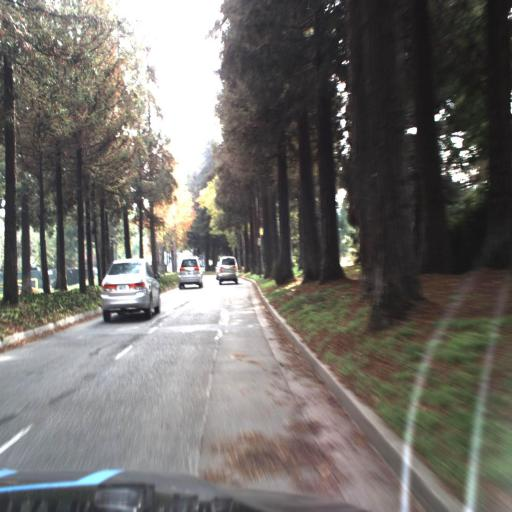
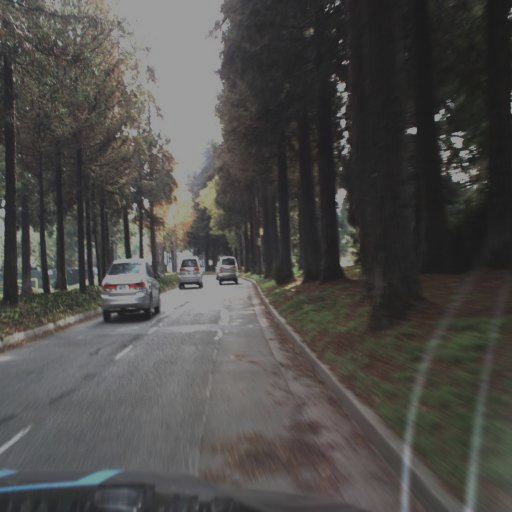
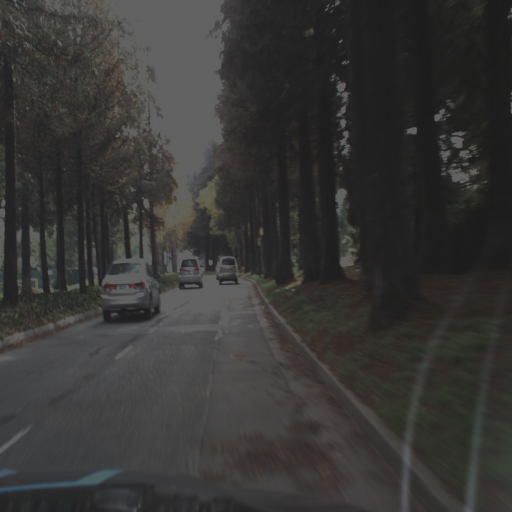

In [13]:
#basic example using OpenCV to adjust the brightness and contrast of an image to make it look duskier
#see https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python for an example
# alpha is the contrast value. To lower the contrast, use 0 < alpha < 1. And for higher contrast use alpha > 1.
# beta is the brightness value. A good range for brightness value is [-127, 127]
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageEnhance
from IPython.display import display, HTML
import io
import base64
import random
file_name = random.choice(os.listdir(sample_folder_size_images))
print(file_name)
image_path = os.path.join(sample_folder_size_images, os.path.splitext(file_name)[0] + ".jpg")


def adjust_brightness_contrast_side_by_side(image_path, contrast, brightness):
    # Open the image
    image = Image.open(image_path)
    
    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1 + brightness / 100)  # Scale brightness appropriately
    
    return image

def adjust_brightness_contrast(image_path, alpha, beta):
    # Load the image
    image = Image.open(image_path)
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    # Adjust brightness and contrast
    adjusted_image_np = cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
    return adjusted_image_np

def image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# Original Image
image = Image.open(image_path)
original_image_base64 = image_to_base64(image)

# Adjusted Images
adjustments = [
    {"contrast": 0.8, "brightness": -30, "description": "Duskier Image proposal contrast=0.4 brightness=-30, gebruikt in lichte augmentatie"},
    {"contrast": 0.6, "brightness": -50, "description": "Duskier Image proposal contrast=0.6 brightness=-30, gebruikt in zware augmentatie"},
]

html_content = "<div style='display: flex; flex-wrap: wrap;'>"

# Original Image
html_content += "<div style='margin: 10px; text-align: center;'><p>Original Image</p>"
html_content += "<img src='data:image/png;base64,{}' style='max-width: 400px;'><br></div>".format(original_image_base64)

# Adjusted Images
for adj in adjustments:
    adjusted_image = adjust_brightness_contrast_side_by_side(image_path, adj["contrast"], adj["brightness"])
    adjusted_image_base64 = image_to_base64(adjusted_image)
    html_content += "<div style='margin: 10px; text-align: center;'><p>{}</p>".format(adj["description"])
    html_content += "<img src='data:image/png;base64,{}' style='max-width: 400px;'><br></div>".format(adjusted_image_base64)

html_content += "</div>"

display(HTML(html_content))

## 1.3 Training Sets aanmaken

### 1.3.1 Training Sets obv augmentatie

In [4]:
#Foto's willekerig opdelen in trainingsets (folders bevatten dan de labels en images die bij elkaar horen)
#1 ongewijzigde beelden
#2 lichte_augmentatie beelden
#3 zware_augmentatie beelden

import os
import random
import shutil

# Create training folders
if not os.path.exists(training_sets_folder):
       os.makedirs(training_sets_folder)

# Function to create folders if they don't exist
def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Target folders
target_folders = ["ongewijzigd", "lichte_augmentatie", "zware_augmentatie"]

# Create target folders
create_folders(target_folders)

# Function to divide images and corresponding labels into three folders randomly
def divide_images(target_folders):
    # Get the list of image files
    image_files = [f for f in os.listdir(sample_folder_size_images) if f.endswith('.jpg')]

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate how many images to put in each folder
    images_per_folder = len(image_files) // len(target_folders)
    print("images_per_folder: ", images_per_folder)
    # Distribute images to folders
    for i, folder in enumerate(target_folders):
        start_index = i * images_per_folder
        end_index = start_index + images_per_folder if i < len(target_folders) - 1 else len(image_files)
        teller = 0
        for image_file in image_files[start_index:end_index]:
            source_path = os.path.join(sample_folder_size_images, image_file)
            target_path = os.path.join(os.path.join(training_sets_folder, folder), image_file)
            shutil.copy(source_path, target_path)
            # Load corresponding label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(sample_folder_size_labels, label_file)
            if not os.path.exists(label_path):
                print(f"Label file not found for {image_file}")
                continue
            target_path = os.path.join(os.path.join(training_sets_folder, folder), label_file)
            shutil.copy(label_path, target_path)
        teller = 0
# Divide images into three folders randomly
divide_images(target_folders)

print("Images and labels divided into three folders successfully.")

images_per_folder:  1008
Images and labels divided into three folders successfully.


#### 1.3.1 Augmentatie toepassen in de folders overdag_augmentatie en augmentatie

In [11]:
import os

def adjust_images_in_folder(folder_path, alpha, beta):
    # loop over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith('.jpg'):
            # Read the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                # Adjust brightness and contrast
                image = Image.open(image_path)
                image_np = np.array(image)
                adjusted_image_np = adjust_brightness_contrast(image_path,alpha, beta)
                #adjusted_image_np = cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
                # Overwrite the original image
                cv2.imwrite(image_path, adjusted_image_np)
    print(f"Adjusted and overwritten: {folder_path}")

# Adjust images in the folders
adjust_images_in_folder(os.path.join(training_sets_folder, "lichte_augmentatie"), 0.8, -30)
adjust_images_in_folder(os.path.join(training_sets_folder, "zware_augmentatie"), 0.6, -50)

Adjusted and overwritten: ./sampleSize10000\training_sets\lichte_augmentatie
Adjusted and overwritten: ./sampleSize10000\training_sets\zware_augmentatie


### 1.3.2 Training Sets verder opsplitsen obv treshhold

In [12]:
#Check of alle beelden wel een label-file hebben (anders kan je geen bounding boxes berekenen)
import os

def count_images_without_label(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    count_images_without_label = 0
    for file in image_files:
      # Load corresponding label file
      label_file = os.path.splitext(file)[0] + ".txt"
      label_path = os.path.join(folder_path, label_file)
      if not os.path.exists(label_path):
        count_images_without_label +=1
    return  count_images_without_label

print("aantal beelden zonder labelfile")
print(count_images_without_label(os.path.join(training_sets_folder, "ongewijzigd")))
print(count_images_without_label(os.path.join(training_sets_folder, "zware_augmentatie")))
print(count_images_without_label(os.path.join(training_sets_folder, "lichte_augmentatie")))

aantal beelden zonder labelfile
0
0
0


In [10]:
#tellen van auto's in 1 label-file
import os

def calculateNumberOfCars(label_file, class_ids):
    #returns the number of cars in the label_file
    number_cars = 0
    # Iterate through each line
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Parse label file
            label = line.strip().split()
            class_id = int(label[0])
            if class_id in class_ids:
              number_cars += 1
    return number_cars

In [11]:
#functie: gemiddelde en mediaan berekenen van aantal auto's per beeld in de folder
#returns a DataFrame containing IDs and their respective percentages, along with the total average percentage and median percentage across all files.
import os
import pandas as pd
import numpy as np

def calculate_total_average_median_percentage(source_folder):
    # Get list of label files
    label_files = [f for f in os.listdir(source_folder) if f.endswith('.txt')]
    total_average_percentage = 0

    # Create an empty list to store the data
    data = []

    # Iterate over label files and calculate percentage
    for idx, label_file in enumerate(label_files, start=1):
        label_path = os.path.join(source_folder, label_file)
        percentage = calculateNumberOfCars(label_path, [2])
        total_average_percentage += percentage
        data.append((idx, percentage))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['ID', 'Percentage'])

    # Calculate total average percentage
    total_average_percentage /= len(label_files)

    # Calculate median percentage
    median_percentage = np.median(df['Percentage'])

    return df, total_average_percentage, median_percentage

In [12]:
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(sample_folder_size_labels)
print(f"Average number of cars in the folder {sample_folder_size_labels}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "zware_augmentatie")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "lichte_augmentatie")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "ongewijzigd")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)

Average number of cars in the folder ./sampleSize10000\labels: 4.554563492063492   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\zware_augmentatie: 4.597222222222222   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\lichte_augmentatie: 4.455357142857143   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\ongewijzigd: 4.611111111111111   median_number_of_cars: 4.0


In [16]:
#trainingsets verder opdelen qua tresh-hold (bevatten labels en images)
#treshhold = aantal auto's per beeld
#Treshhold zetten zodat we gebalanceerde dataset bereiken

import os
import random
import shutil

# Target folders
target_folders = ["onder_de_grens", "boven_de_grens"]

# Function to create folders if they don't exist
def create_folders(training_sets_folder, folders):
    for folder in folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Create target folders
create_folders(os.path.join(training_sets_folder, "ongewijzigd"),target_folders)
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie"),target_folders)
create_folders(os.path.join(training_sets_folder, "zware_augmentatie"),target_folders)

def copy_images_based_on_threshold(source_folder, threshold):
    # Get list of label files in the source folder
    label_files = [f for f in os.listdir(source_folder) if f.endswith('.txt')]
    # Iterate through each image file
    for label_file in label_files:
        label_path = os.path.join(source_folder, label_file)
        image_file = os.path.splitext(label_file)[0] + ".jpg"
        # Decide which target folder to copy the image to based on brightness threshold
        if calculateNumberOfCars(label_path,[2]) > threshold:
            target_path_image = os.path.join(source_folder, "boven_de_grens", image_file)
            target_path_label = os.path.join(source_folder, "boven_de_grens", label_file)
        else:
            target_path_image = os.path.join(source_folder, "onder_de_grens", image_file)
            target_path_label = os.path.join(source_folder, "onder_de_grens", label_file)
        # Copy labelfile to the appropriate target folder
        shutil.copy(label_path, target_path_label)

        #copy image-file to the appropriate target folder
        source_path = os.path.join(source_folder, image_file)
        shutil.copy(source_path, target_path_image)

# Divide images into three folders randomly
copy_images_based_on_threshold(os.path.join(training_sets_folder, "ongewijzigd"),4)

copy_images_based_on_threshold(os.path.join(training_sets_folder, "lichte_augmentatie"),4)

copy_images_based_on_threshold(os.path.join(training_sets_folder, "zware_augmentatie"),4)


#tellingen en uitprinten aantal bestanden per folder
def count_files(folder_path):
  num_files = 0
  for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
      num_files += 1
  return num_files

#check op balans in de datasets
folder_path = os.path.join(training_sets_folder, "ongewijzigd","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} images in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "ongewijzigd","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "lichte_augmentatie","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "lichte_augmentatie","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "zware_augmentatie","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "zware_augmentatie","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
print("Met deze folders gaan we de predictie, training & validatie doen")

There are 585.0 images in the folder ./sampleSize10000\training_sets\ongewijzigd\onder_de_grens.
There are 423.0 files in the folder ./sampleSize10000\training_sets\ongewijzigd\boven_de_grens.
There are 594.0 files in the folder ./sampleSize10000\training_sets\lichte_augmentatie\onder_de_grens.
There are 414.0 files in the folder ./sampleSize10000\training_sets\lichte_augmentatie\boven_de_grens.
There are 574.0 files in the folder ./sampleSize10000\training_sets\zware_augmentatie\onder_de_grens.
There are 434.0 files in the folder ./sampleSize10000\training_sets\zware_augmentatie\boven_de_grens.
Met deze folders gaan we de predictie, training & validatie doen


# 2 Afhankelijke variabelen

### 2.1 IoU

Intersection over Union measures the overlap between two bounding boxes, typically the predicted bounding box and the ground truth bounding box of an object. If the predicted bounding box overlaps perfectly with the ground truth bounding box, the IoU would be 1. If there's no overlap at all, the IoU would be 0.

Vele beelden hebben meerdere auto's dus meerdere boxen. Voor het bepalen van de IoU gaan we de truth-boxes 1 voor 1 vergelijken met de predicted boxes en enkel de box overhouden die hiermee maximaal matcht.


In [18]:
import statistics
#voorbeeld onder https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def calculate_iou(gt_box, pred_box, eps=1e-7):
    """
    Calculates the IoU between two bounding boxes.
    Source code:https://docs.ultralytics.com/reference/utils/metrics/#ultralytics.utils.metrics.bbox_iou
    Args:
        gt_box (list): Ground truth bounding box (classid, x_center, y_center, width, height).
        pred_box (list): Predicted bounding box (classid, x_center, y_center, width, height).

    Returns:
        float: The IoU value between the two boxes.
    """
    # Extract coordinates for both boxes
    x1, y1, w1, h1  = map(float, gt_box.split()[1:])
    x2, y2, w2, h2 = map(float, pred_box.split()[1:])
    w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
    b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
    b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    
    # Intersection area
    inter = (max(0,min(b1_x2,b2_x2) - max(b1_x1,b2_x1))) * max(0,(min(b1_y2,b2_y2) - max(b1_y1,b2_y1)))

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    return iou


def calculate_multiple_iou(gt_boxes, pred_boxes, class_ids):
    """
    Calculates IoU for each ground truth box and the best matching predicted box.

    Args:
        gt_boxes (list of lists): List of ground truth bounding boxes (classid, x_center, y_center, width, height).
        pred_boxes (list of lists): List of predicted bounding boxes (classid, x_center, y_center, width, height).

    Returns:
        list of floats: List of IoU values for each ground truth box.
    """

    iou_list = []
    with open(gt_boxes, 'r') as gt_file:
        gt_boxes = gt_file.readlines()
        for gt_box in gt_boxes:
            label_truth = gt_box.strip().split()
            class_id_truth = int(label_truth[0])
            if class_id_truth == class_ids:
              max_iou = 0.0
              best_pred_box = None
              with open(pred_boxes, 'r') as pred_file:
                  pred_boxes2 = pred_file.readlines()
                  for pred_box in pred_boxes2:
                      label_predict = pred_box.strip().split()
                      class_id_predict = int(label_predict[0])
                      if class_id_predict in [class_ids]:
                          iou = calculate_iou(gt_box, pred_box)
                          if iou > max_iou:
                              max_iou = iou
                              best_pred_box = pred_box
              iou_list.append(max_iou)
    return iou_list

def calculate_IoU_Percentage(index,phase,truth_folder, predict_folder,class_ids):
    """
    Calculates detected car percentage for all labels in a folder
    Args:
        folder containing the labels
    Returns:
        list of percentages (length of list is the number of label-files)
    """
    outer_list = []
    # Get list of label files in the folder
    truth_label_files = [f for f in os.listdir(truth_folder) if f.endswith('.txt')]
    # Iterate through each label file
    for idx, label_file in enumerate(truth_label_files, start=index):
        truth_path_label = os.path.join(truth_folder, label_file)
        predict_path_label = os.path.join(predict_folder, label_file)
        #controle voor als Yolov8 geen labelfile heeft gemaakt wegens geen detectie
        if os.path.exists(predict_path_label):
            iou_list = calculate_multiple_iou(truth_path_label,predict_path_label,class_ids)
        else:
            iou_list = [0]
        if iou_list:
            percentage = statistics.mean(iou_list)
        else:
            percentage = 0
        outer_list.append((phase,idx, percentage))
    return outer_list

### 2.2 auto's tellen

In [19]:
#vergelijken autotellingen uit 2 folders
import pandas as pd
import os

def calculateCarPercentage(index,phase,truth_folder, predict_folder, class_ids):
    """
    Calculates detected car percentage for all labels in a folder
    Class_ids for the cars is 2
    Args:
        folder containing the labels
    Returns:
        list of percentages (length of list is the number of label-files)
    """
    outer_list = []
    # Get list of label files in the folder
    truth_label_files = [f for f in os.listdir(truth_folder) if f.endswith('.txt')]
    # Iterate through each label file
    for idx, label_file in enumerate(truth_label_files, start=index):
        truth_path_label = os.path.join(truth_folder, label_file)
        truth_number_cars = calculateNumberOfCars(truth_path_label, class_ids)
        predict_path_label = os.path.join(predict_folder, label_file)
        #controle voor als Yolov8 geen labelfile heeft gemaakt wegens geen detectie
        if os.path.exists(predict_path_label):
            predict_number_cars = calculateNumberOfCars(predict_path_label, class_ids)
        else:
            predict_number_cars = 0
        if truth_number_cars != 0:
           percentage =  predict_number_cars/truth_number_cars
        else:
           percentage = 0
        outer_list.append((phase,idx, percentage))
    return outer_list

## 2.2 Predictie door YoloV8 model

#### 2.2.1 IoU-resultaten van predictie YoloV8 model op 1 beeld

File name:  1478731992346617871_jpg.rf.f22d7642203ad0851f89b704644f7de6.txt
Truth label file
2 0.4833984375 0.51953125 0.0908203125 0.1298828125
2 0.59765625 0.501953125 0.03515625 0.04296875
2 0.6474609375 0.5048828125 0.0576171875 0.0634765625
2 0.7255859375 0.521484375 0.087890625 0.08984375
2 0.904296875 0.5078125 0.080078125 0.111328125

Predict label file
0 0.720434 0.522621 0.0865099 0.0793952
0 0.484606 0.522906 0.0811127 0.103125
0 0.643562 0.509078 0.0581729 0.054632
0 0.599225 0.505323 0.0335623 0.0273886

IoU boxes percentage:  [0.0, 0.0, 0.0, 0.0, 0.0]
Average:  0.0
1478731992346617871_jpg.rf.f22d7642203ad0851f89b704644f7de6.txt

truth box rood
predict box geel


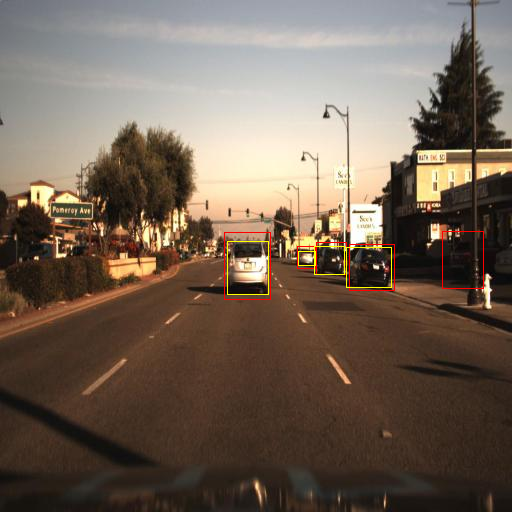

In [16]:
import statistics
import random
file_name = random.choice(os.listdir(sample_folder_size_labels))
print("File name: ", file_name)

truth_file = os.path.join(sample_folder_size_labels, file_name)
predict_file = os.path.join(sample_folder_predict, file_name)

with open(truth_file, "r") as file:
    # Read the entire content of the file
    content = file.read()
    # Print the content
    print("Truth label file")
    print(content)

with open(predict_file, "r") as file:
    # Read the entire content of the file
    content = file.read()
    # Print the content
    print("Predict label file")
    print(content)


print("IoU boxes percentage: ", calculate_multiple_iou(truth_file,predict_file,2 ))
print("Average: ",statistics.mean(calculate_multiple_iou(truth_file,predict_file,2 )))
      
#Tonen van bounding boxes rond de auto's op 1 willekeurig gekozen image
#Auto's zijn class_id 1 in de truth label-file en class_id 2 in de predict label-file
#vervangen door https://stackoverflow.com/questions/23720875/opencv-draw-a-rectangle-around-a-region
import cv2
from PIL import Image, ImageDraw

# Load the image
image = Image.open(os.path.join(sample_folder_size_images, os.path.splitext(file_name)[0] + ".jpg"))
draw = ImageDraw.Draw(image)

print(file_name)
# Load corresponding truth-label file
with open(os.path.join(sample_folder_size_labels, file_name), 'r') as f:
    lines = f.readlines()
    
# Parse bounding box data and draw on the image
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #class id 1 are cars,
    if class_id == 2:
        width *= image.width
        height *= image.height
        x_center *= image.width
        y_center *= image.height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        # Draw bounding box on the image
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

print ("")
# Load corresponding predict-label file
with open(os.path.join(sample_folder_predict, file_name), 'r') as f:
    lines = f.readlines()

# Read label file and draw bounding boxes
for line in lines:
  class_id, x_center, y_center, width, height = map(float, line.strip().split())
  if class_id == 2:
      width *= image.width
      height *= image.height
      x_center *= image.width
      y_center *= image.height
      x_min = x_center - width / 2
      y_min = y_center - height / 2
      x_max = x_center + width / 2
      y_max = y_center + height / 2

      # Draw bounding box on the image
      draw.rectangle([x_min, y_min, x_max, y_max], outline="yellow")
# Show the image with bounding boxes
print("truth box rood")
print("predict box geel")
display(image)

#### 2.2.2 Autotellingen-resultaten van predictie YoloV8 model op 1 beeld

File name:  1478896581592084346_jpg.rf.e8oD6wuf9UUEcdgBJ7M0.txt
code vanuit truth-labels-file
2 0.034895833333333334 0.5958333333333333 0.06875 0.12000000000000001

2 0.1140625 0.5625 0.09479166666666666 0.09166666666666667

2 0.43124999999999997 0.5258333333333334 0.04791666666666666 0.07166666666666667

truth box rood
predict box geel


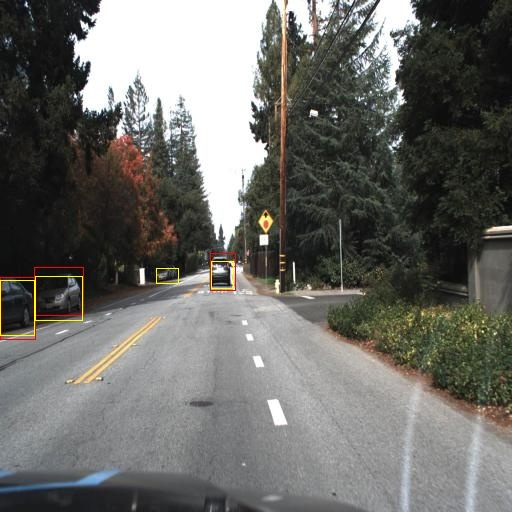

code vanuit predict-labels-file
0 0.114622 0.576055 0.0908996 0.0845243

0 0.033754 0.594633 0.0675004 0.107529

0 0.429197 0.531433 0.0425573 0.0523537

0 0.322987 0.533191 0.0414628 0.0298281

aantal auto's truth 3.
aantal auto's predict 4.
percentage herkende auto's: 1.3333333333333333


In [35]:
import os

file_name = random.choice(os.listdir(sample_folder_size_labels))
print("File name: ", file_name)

truth_file = os.path.join(sample_folder_size_labels, file_name)
predict_file = os.path.join(sample_folder_predict, file_name)

# Load and print label files
with open(truth_file, 'r') as f:
    lines = f.readlines()
    print("code vanuit truth-labels-file")
    for line in lines:
      print(line)

print("truth box rood")
print("predict box geel")

#display image
image = Image.open(os.path.join(bounding_box_folder , os.path.splitext(file_name)[0] + ".jpg"))
display(image)

with open(predict_file, 'r') as f:
    lines = f.readlines()
    print("code vanuit predict-labels-file")
    for line in lines:
      print(line)

truth_number_cars= calculateNumberOfCars(truth_file,[2])
predict_number_cars = calculateNumberOfCars(predict_file,[2])

print(f"aantal auto's truth {truth_number_cars}.")
print(f"aantal auto's predict {predict_number_cars}.")
print("percentage herkende auto's:", predict_number_cars/truth_number_cars)

# 3 Training

## 3.1 Voorbereiding

In [62]:
#aanmaken van de training, validatie en test-folders voor alle datasets 
# Aanmaken folders
target_folders = ["images", "labels"]
sub_target_folders = ["train", "val","test"]

# Function to create folders if they don't exist
def create_folders(training_sets_folder):
    for folder in target_folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            for subfolder in sub_target_folders:
                sub_folder_path = os.path.join(folder_path, subfolder)
                os.makedirs(sub_folder_path)

# Create target folders
create_folders(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens"))
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens"))
create_folders(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens"))
create_folders(training_sets_folder)

In [63]:
#aanpassen van de class_id's in de label-files want in de Yaml-file van het model 
#staat maar 1 klasse (we detecteren enkel auto's), dus deze klasse moet 0 zijn 

import os

# Function to update class IDs
def update_class_ids(label_file):
    updated_lines = []
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id == 2:
                parts[0] = '0'  
                updated_lines.append(' '.join(parts) + '\n')
    with open(label_file, 'w') as file:
        file.writelines(updated_lines)

# Process all label files in the directory
def update_class_ids_folder(folder_path):
    # Get list of all label files in the predict folder
    label_txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    for label_file in label_txt_files:
        file_path = os.path.join(folder_path, label_file)
        update_class_ids(file_path)

In [64]:
#80-10-10 split voor training-validation-test
from sklearn.model_selection import train_test_split
import os
import shutil

def splitten (path):
    # Get list of image files
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    # Split dataset into train, val, and test sets
    train_files, temp_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42) 
    # Iterate through each image file
    for image_train_file in train_files:
        shutil.copy(image_train_file, os.path.join(path,"images/train"))
        shutil.copy(os.path.join(os.path.dirname(image_train_file),os.path.basename(image_train_file).replace('.jpg', '.txt')), os.path.join(path,"labels/train"))
    for image_val_file in val_files:
        shutil.copy(image_val_file, os.path.join(path,"images/val"))
        shutil.copy(os.path.join(os.path.dirname(image_val_file),os.path.basename(image_val_file).replace('.jpg', '.txt')), os.path.join(path,"labels/val"))    
    #unifying the testset (same test set for all models, so destination is not set by path)
    for image_test_file in test_files:
        shutil.copy(image_test_file, os.path.join(training_sets_folder,"images/test"))
        shutil.copy(os.path.join(os.path.dirname(image_test_file),os.path.basename(image_test_file).replace('.jpg', '.txt')), os.path.join(training_sets_folder,"labels/test"))


splitten(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens","labels/val"))

splitten(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens","labels/val"))

splitten(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens","labels/val"))

splitten(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens","labels/val"))

splitten(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens","labels/val"))

splitten(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens"))
update_class_ids_folder(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens","labels/train"))
update_class_ids_folder(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens","labels/val"))

update_class_ids_folder(os.path.join(training_sets_folder, "labels/test"))
update_class_ids_folder(os.path.join(sample_folder_size, "Yolo_output", "predict/labels"))

### Benchmarks aanmaken op de testset met YOLOv8 predict out of the box

In [ ]:
import pandas as pd

df_final= pd.DataFrame()

def update_scores(index,phase):
    # Construct the full paths
    truth_path = os.path.join(training_sets_folder,"labels/test")
    predict_path = os.path.join(sample_folder_size, "Yolo_output", "predict/labels")
    
    # Call the functions to get the benchmark results
    IOU_benchmark = calculate_IoU_Percentage(index,phase, truth_path, predict_path, 0)
    NDC_benchmark = calculateCarPercentage(index,phase, truth_path, predict_path, [0])

    # Create DataFrames from the results
    df_IOU = pd.DataFrame(IOU_benchmark, columns=['Phase', 'ID', 'IOU'])
    df_NDC = pd.DataFrame(NDC_benchmark, columns=['Phase', 'ID', 'NDC'])

    # Merge the DataFrames on 'Benchmark' and 'ID'
    merged_df = pd.merge(df_NDC, df_IOU, on=["Phase", "ID"])

    return merged_df

df_final = update_scores(1,"Benchmark")

In [ ]:
print(df_final.to_string())

In [21]:
import pandas as pd
# Calculate mean, median, standard deviation, and variance per benchmark-string for IOU
iou_statistics = df_final.groupby('Phase')['IOU'].agg(['mean', 'median', 'std', 'var']).reset_index()
iou_statistics.columns = ['Phase', 'IOU Mean', 'IOU Median', 'IOU Std', 'IOU Variance']

# Calculate mean, median, standard deviation, and variance per benchmark-string for NDC
ndc_statistics = df_final.groupby('Phase')['NDC'].agg(['mean', 'median', 'std', 'var']).reset_index()
ndc_statistics.columns = ['Phase', 'NDC Mean', 'NDC Median', 'NDC Std', 'NDC Variance']

# Convert statistics DataFrames to HTML tables
iou_html = iou_statistics.to_html(index=False)
ndc_html = ndc_statistics.to_html(index=False)

# Display HTML tables in Jupyter Notebook
from IPython.display import display, HTML

display(HTML(iou_html))

display(HTML(ndc_html))


Phase,IOU Mean,IOU Median,IOU Std,IOU Variance
Benchmark,0.53425,0.570749,0.234851,0.055155


Phase,NDC Mean,NDC Median,NDC Std,NDC Variance
Benchmark,0.882485,0.857143,0.525772,0.276436


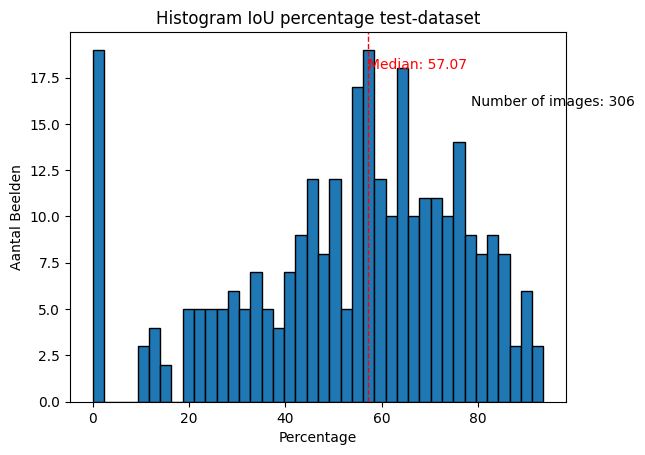

In [22]:
#voorbeeldplot 1 folder
import matplotlib.pyplot as plt

#df_filtered = df_final[df_final['Phase'] == 'BM_ongewijzigde beelden onder de grens']

# Specify number of bins for the histogram
num_bins = 40

# Plot histogram
plt.hist(df_final['IOU'] * 100, bins=num_bins, edgecolor='black')

# Calculate median
median_percentage = (df_final['IOU']* 100).median()

# Add vertical line for median
plt.axvline(median_percentage, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Percentage')
plt.ylabel('Aantal Beelden')
plt.title('Histogram IoU percentage test-dataset')

# Show median value
plt.text(median_percentage, plt.ylim()[1]*0.9, f'Median: {median_percentage:.2f}', color='red')

# Calculate number of unique IDs
num_unique_ids = df_final['ID'].nunique()

# Add legend
plt.text(plt.xlim()[1]*0.8, plt.ylim()[1]*0.8, f'Number of images: {num_unique_ids}', fontsize=10)

# Show plot
plt.show()


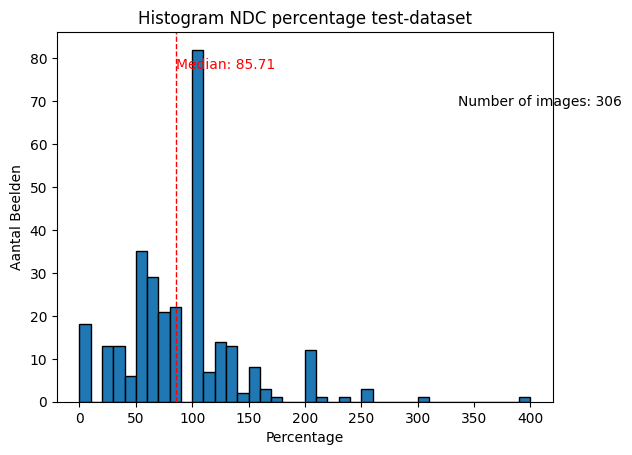

In [24]:
#voorbeeldplot 1 folder
import matplotlib.pyplot as plt

#df_filtered = df_final[df_final['Phase'] == 'BM_ongewijzigde beelden onder de grens']

# Specify number of bins for the histogram
num_bins = 40

# Plot histogram
plt.hist(df_final['NDC'] * 100, bins=num_bins, edgecolor='black')

# Calculate median
median_percentage = (df_final['NDC']* 100).median()

# Add vertical line for median
plt.axvline(median_percentage, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Percentage')
plt.ylabel('Aantal Beelden')
plt.title('Histogram NDC percentage test-dataset')

# Show median value
plt.text(median_percentage, plt.ylim()[1]*0.9, f'Median: {median_percentage:.2f}', color='red')

# Calculate number of unique IDs
num_unique_ids = df_final['ID'].nunique()

# Add legend
plt.text(plt.xlim()[1]*0.8, plt.ylim()[1]*0.8, f'Number of images: {num_unique_ids}', fontsize=10)

# Show plot
plt.show()


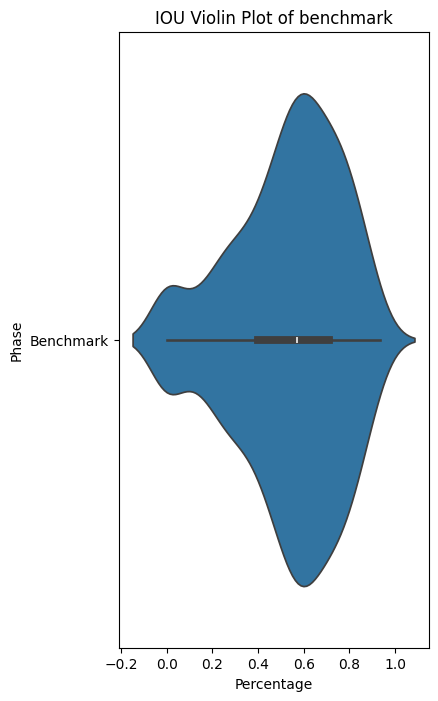

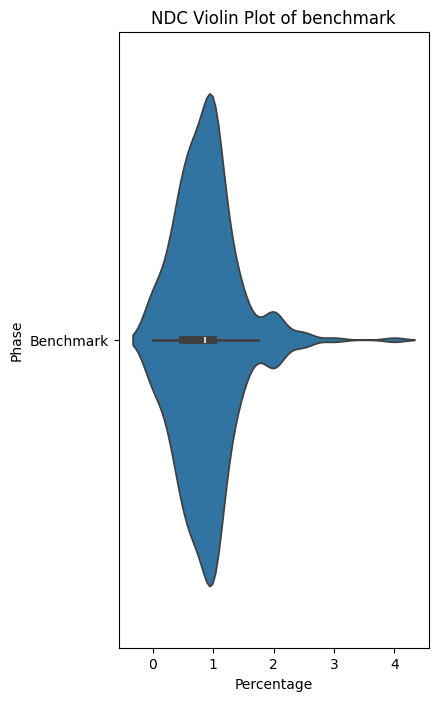

In [27]:
#voorbeeldplot alle folders
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_final[df_final['Phase'].str.startswith('BM_')]

# Box Plot
#plt.figure(figsize=(6, 12))
#sns.boxplot(y='Benchmark', x='Percentage', data=df_benchmark)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Box Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Violin Plot ==> It shows the median, quartiles, and potential outliers. but also shows the density of the data at 
# different values. This can provide more insight into the distribution.
plt.figure(figsize=(4, 8))
sns.violinplot(y='Phase', x='IOU', data=df_final)
plt.ylabel('Phase')
plt.xlabel('Percentage')
plt.title('IOU Violin Plot of benchmark')
plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
plt.show()

plt.figure(figsize=(4, 8))
sns.violinplot(y='Phase', x='NDC', data=df_final)
plt.ylabel('Phase')
plt.xlabel('Percentage')
plt.title('NDC Violin Plot of benchmark')
plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
plt.show()

# Strip Plot
#plt.figure(figsize=(6, 12))
#sns.stripplot(y='Benchmark', x='Percentage', data=df_benchmark, jitter=True)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Strip Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Bar Plot of Means with Error Bars
#means = df_benchmark.groupby('Benchmark')['Percentage'].mean()
#stds = df_benchmark.groupby('Benchmark')['Percentage'].std()

#plt.figure(figsize=(6, 12))
#means.plot(kind='barh', xerr=stds, capsize=4, color='skyblue', edgecolor='black')
#plt.ylabel('Benchmark')
#plt.xlabel('Mean Percentage')
#plt.title('Mean Percentage by Benchmark with Error Bars')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()


## 3.2 Training en validatie (op unified testset) van de 6 datasets

In [ ]:
#import model
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

model = YOLO('yolov8n.pt')

results = model.train(data='./YAML/data_ongewijzigd_onder_de_grens.yaml', patience= 5, epochs= 20, imgsz=512, 
                      project=os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"),
                      name="training_ongewijzigde_beelden_onder_de_grens") 

# wat staat er nog allemaal in de folder runs/train en hoe dit te interpreteren? Er staat bvb. MAP in, F1, ...
path = os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens", "training_ongewijzigde_beelden_onder_de_grens")
model = YOLO(os.path.join(path,"weights/best.pt"))

model.val(data='./YAML/data_ongewijzigd_onder_de_grens.yaml',
               project=os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"),name="validatie_ongewijzigde_beelden_onder_de_grens") 

In [ ]:
#rest van datasets trainen en valideren
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

import os
import shutil

def train_and_val (previous_result_dir, current_result_dir, current_val_dir,previous_training_set,current_training_set,yaml_file):
# training
    path = os.path.join(training_sets_folder, previous_training_set, previous_result_dir)
    model = YOLO(os.path.join(path,"weights/best.pt")) 
    model.train(data=os.path.join('./YAML', yaml_file), patience= 5, epochs= 20, imgsz=512, 
                project=os.path.join(training_sets_folder, current_training_set),name=current_result_dir) 
# validation
    path = os.path.join(training_sets_folder, current_training_set, current_result_dir)
    model = YOLO(os.path.join(path,"weights/best.pt"))
    model.val(data=os.path.join('./YAML', yaml_file),
                   project=os.path.join(training_sets_folder, current_training_set),name=current_val_dir) 
                 
train_and_val("training_ongewijzigde_beelden_onder_de_grens", 
              "training_ongewijzigde_beelden_boven_de_grens",
              "validatie_ongewijzigde_beelden_boven_de_grens",
              "ongewijzigd/onder_de_grens", 
              "ongewijzigd/boven_de_grens", 
              "data_ongewijzigd_boven_de_grens.yaml")  
                 
train_and_val("training_ongewijzigde_beelden_boven_de_grens", 
              "training_lichte_augmentatie_beelden_onder_de_grens",
              "validatie_lichte_augmentatie_beelden_onder_de_grens",
              "ongewijzigd/boven_de_grens", 
              "lichte_augmentatie/onder_de_grens", 
              "data_lichte_augmentatie_onder_de_grens.yaml")  
                 
train_and_val("training_lichte_augmentatie_beelden_onder_de_grens", 
              "training_lichte_augmentatie_beelden_boven_de_grens",
              "validatie_lichte_augmentatie_beelden_boven_de_grens",
              "lichte_augmentatie/onder_de_grens", 
              "lichte_augmentatie/boven_de_grens", 
              "data_lichte_augmentatie_boven_de_grens.yaml")  
                 
train_and_val("training_lichte_augmentatie_beelden_boven_de_grens", 
              "training_zware_augmentatie_beelden_onder_de_grens",
              "validatie_zware_augmentatie_beelden_onder_de_grens",
              "lichte_augmentatie/boven_de_grens", 
              "zware_augmentatie/onder_de_grens", 
              "data_zware_augmentatie_onder_de_grens.yaml")  
                 
train_and_val("training_zware_augmentatie_beelden_onder_de_grens", 
              "training_zware_augmentatie_beelden_boven_de_grens",
              "validatie_zware_augmentatie_beelden_boven_de_grens",
              "zware_augmentatie/onder_de_grens", 
              "zware_augmentatie/boven_de_grens", 
              "data_zware_augmentatie_boven_de_grens.yaml")  

# 4 scores aanmaken met getrainde modellen en statistieken trekken

## 4.1 predictie met getrainde modellen

In [ ]:
#laden model, predict laten lopen met aanmaak labels
#rest van datasets trainen en valideren
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

path = os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens")
testset_path = os.path.join(training_sets_folder, "images/test")
model = YOLO(os.path.join(path,"training_ongewijzigde_beelden_onder_de_grens","weights/best.pt"))
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)

path = os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens")
model = YOLO(os.path.join(path,"training_ongewijzigde_beelden_boven_de_grens","weights/best.pt")) 
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)
             
path = os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens")
model = YOLO(os.path.join(path,"training_lichte_augmentatie_beelden_onder_de_grens","weights/best.pt")) 
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)

path = os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens")
model = YOLO(os.path.join(path,"training_lichte_augmentatie_beelden_boven_de_grens","weights/best.pt"))
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)

path = os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens")
model = YOLO(os.path.join(path,"training_zware_augmentatie_beelden_onder_de_grens","weights/best.pt"))
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)

path = os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens")
model = YOLO(os.path.join(path,"training_zware_augmentatie_beelden_boven_de_grens","weights/best.pt"))
predict = model.predict(source = testset_path, save_txt = True, exist_ok=True, project=path)


In [36]:
def update_scores_aftertraining (index,path, phase):
    # Construct the full paths
    truth_path = os.path.join(training_sets_folder,"labels/test")
    #images/truth aanmaken voor de labels in predict en dit als truth path zetten
    predict_path = os.path.join(training_sets_folder, path, "predict/labels")

    # Call the functions to get the benchmark results
    IOU_benchmark = calculate_IoU_Percentage(index,phase, truth_path, predict_path, 0)
    NDC_benchmark = calculateCarPercentage(index,phase, truth_path, predict_path, [0])

    # Create DataFrames from the results
    df_IOU = pd.DataFrame(IOU_benchmark, columns=['Phase', 'ID', 'IOU'])
    df_NDC = pd.DataFrame(NDC_benchmark, columns=['Phase', 'ID', 'NDC'])

    # Merge the DataFrames on 'Benchmark' and 'ID'
    merged_df = pd.merge(df_NDC, df_IOU, on=["Phase", "ID"])

    return merged_df

In [37]:
#updaten scores in df_final
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"ongewijzigd/onder_de_grens","T_OO")])
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"ongewijzigd/boven_de_grens","T_OB")])
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"lichte_augmentatie/onder_de_grens","T_LO")])
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"lichte_augmentatie/boven_de_grens","T_LB")])
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"zware_augmentatie/onder_de_grens","T_ZO")])
df_final = pd.concat([df_final,
    update_scores_aftertraining(1,"zware_augmentatie/boven_de_grens","T_ZB")])

In [ ]:
print(df_final.to_string())

## 4.2 statistieken

### 4.2.1 descriptive statistics

In [4]:
# inlezen csv (voor als je alle bovenstaande stappen al hebt doorlopen)
import os
import pandas as pd

df_final= df = pd.read_csv('./output.csv')

In [5]:
import pandas as pd

# Specify the order of the phases
phase_order = ['Benchmark', 'T_OO', 'T_OB', 'T_LO', 'T_LB', 'T_ZO', 'T_ZB']

# Mapping of phase names to desired display names
phase_name_mapping = {
    'Benchmark': 'Benchmark',
    'T_OO': 'Training 1 - unaltered images below the threshold',
    'T_OB': 'Training 2 - unaltered images above the threshold',
    'T_LO': 'Training 3 - slightly augmented images below the threshold',
    'T_LB': 'Training 4 - slightly augmented images above the threshold',
    'T_ZO': 'Training 5 - heavily augmented images below the threshold',
    'T_ZB': 'Training 6 - heavily augmented images above the threshold'
}

# Convert the 'Phase' column to a categorical type with the specified order
df_final['Phase'] = pd.Categorical(df_final['Phase'], categories=phase_order, ordered=True)

# Calculate mean, median, standard deviation, and variance per benchmark-string for IOU
iou_statistics = df_final.groupby('Phase')['IOU'].agg(['mean', 'median', 'std', 'var']).reset_index()
iou_statistics.columns = ['Phase', 'IOU Mean', 'IOU Median', 'IOU Std', 'IOU Variance']

# Calculate mean, median, standard deviation, and variance per benchmark-string for NDC
ndc_statistics = df_final.groupby('Phase')['NDC'].agg(['mean', 'median', 'std', 'var']).reset_index()
ndc_statistics.columns = ['Phase', 'NDC Mean', 'NDC Median', 'NDC Std', 'NDC Variance']

# Map the phase names to the desired display names
iou_statistics['Phase'] = iou_statistics['Phase'].map(phase_name_mapping)
ndc_statistics['Phase'] = ndc_statistics['Phase'].map(phase_name_mapping)

# Convert statistics DataFrames to HTML tables
iou_html = iou_statistics.to_html(index=False)
ndc_html = ndc_statistics.to_html(index=False)

# Display HTML tables in Jupyter Notebook
from IPython.display import display, HTML

display(HTML(iou_html))

display(HTML(ndc_html))

C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_20236\2041741405.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iou_statistics = df_final.groupby('Phase')['IOU'].agg(['mean', 'median', 'std', 'var']).reset_index()
C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_20236\2041741405.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ndc_statistics = df_final.groupby('Phase')['NDC'].agg(['mean', 'median', 'std', 'var']).reset_index()


Phase,IOU Mean,IOU Median,IOU Std,IOU Variance
Benchmark,0.534250,0.570749,0.234851,0.055155
Training 1 - unaltered images below the threshold,0.455082,0.470393,0.269051,0.072389
Training 2 - unaltered images above the threshold,0.474269,0.523806,0.280520,0.078691
Training 3 - slightly augmented images below the threshold,0.564174,0.594237,0.231945,0.053798
Training 4 - slightly augmented images above the threshold,0.634058,0.662644,0.187125,0.035016
Training 5 - heavily augmented images below the threshold,0.542400,0.564274,0.241300,0.058226
Training 6 - heavily augmented images above the threshold,0.631510,0.675548,0.198953,0.039582


Phase,NDC Mean,NDC Median,NDC Std,NDC Variance
Benchmark,0.882485,0.857143,0.525772,0.276436
Training 1 - unaltered images below the threshold,0.621482,0.563492,0.416369,0.173363
Training 2 - unaltered images above the threshold,0.837875,0.750000,0.620654,0.385212
Training 3 - slightly augmented images below the threshold,0.782805,0.750000,0.394040,0.155267
Training 4 - slightly augmented images above the threshold,1.198057,1.000000,0.702748,0.493854
Training 5 - heavily augmented images below the threshold,0.726674,0.666667,0.430105,0.184990
Training 6 - heavily augmented images above the threshold,1.053381,1.000000,0.591096,0.349395


In [46]:
#wegschrijven dataframe naar csv
import os
import pandas as pd

# Full file path
file_path = os.path.join(sample_folder_size, "output.csv")

# Write the DataFrame to a CSV file at the specified path
df_final.to_csv(file_path, index=False)

print(f'DataFrame written to {file_path}')

DataFrame written to ./sampleSize10000\output.csv


In [ ]:
print(df_final.to_string())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the order of the phases
phase_order = ['Benchmark', 'T_OO', 'T_OB', 'T_LO', 'T_LB', 'T_ZO', 'T_ZB'][::-1]

# Mapping of phase names to desired display names
phase_name_mapping = {
    'Benchmark': 'Benchmark',
    'T_OO': 'Training 1 - unaltered images below the threshold',
    'T_OB': 'Training 2 - unaltered images above the threshold',
    'T_LO': 'Training 3 - slightly augmented images below the threshold',
    'T_LB': 'Training 4 - slightly augmented images above the threshold',
    'T_ZO': 'Training 5 - heavily augmented images below the threshold',
    'T_ZB': 'Training 6 - heavily augmented images above the threshold'
}

# Convert the 'Phase' column to a categorical type with the specified order
df_final['Phase'] = pd.Categorical(df_final['Phase'], categories=phase_order, ordered=True)

# Calculate mean, median, standard deviation, and variance per benchmark-string for IOU
iou_statistics = df_final.groupby('Phase')['IOU'].agg(['mean', 'std']).reset_index()
iou_statistics.columns = ['Phase', 'IOU Mean', 'IOU Std']

# Map the phase names to the desired display names
iou_statistics['Phase'] = iou_statistics['Phase'].map(phase_name_mapping)

# Plotting the histogram for IOU Mean
fig, ax1 = plt.subplots()

# Plot the IOU means as horizontal bars
bars = ax1.barh(iou_statistics['Phase'], iou_statistics['IOU Mean'], color='skyblue', label='IOU Mean')

# Plot the IOU standard deviations as a line
ax2 = ax1.twiny()
line, = ax2.plot(iou_statistics['IOU Std'], iou_statistics['Phase'], color='red', marker='o', linestyle='-', label='IOU Std')

# Adding labels and title
ax1.set_ylabel('Phase')
ax1.set_xlabel('IOU Mean', color='skyblue')
ax2.set_xlabel('IOU Std', color='red')
plt.title('IOU Mean and Standard Deviation by training phase')

# Adding legends and positioning them outside the plot area
ax1.legend(handles=[bars, line], loc='center left', bbox_to_anchor=(1.05, 0.5))

# Adjust layout to make room for the legends
fig.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()


In general, the graph shows that the IOU mean increases as the training phase progresses. This suggests that the object detection model is performing better as it is trained with more data or with different data augmentation techniques.

it appears that training with heavily augmented images above the threshold (Training 6) might lead to the best performance in terms of IOU mean and standard deviation.
When the model encounters more complex data with augmentations (Training 3 onwards), its performance might drop as it struggles to adapt to the variations.
The model's ability to handle complex data and achieve good performance later (Training 5 & 6) is a better indicator of its generalizability.

C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_4900\11986620.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  NDC_statistics = df_final.groupby('Phase')['NDC'].agg(['mean', 'std']).reset_index()
C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_4900\11986620.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 0.85, 1])


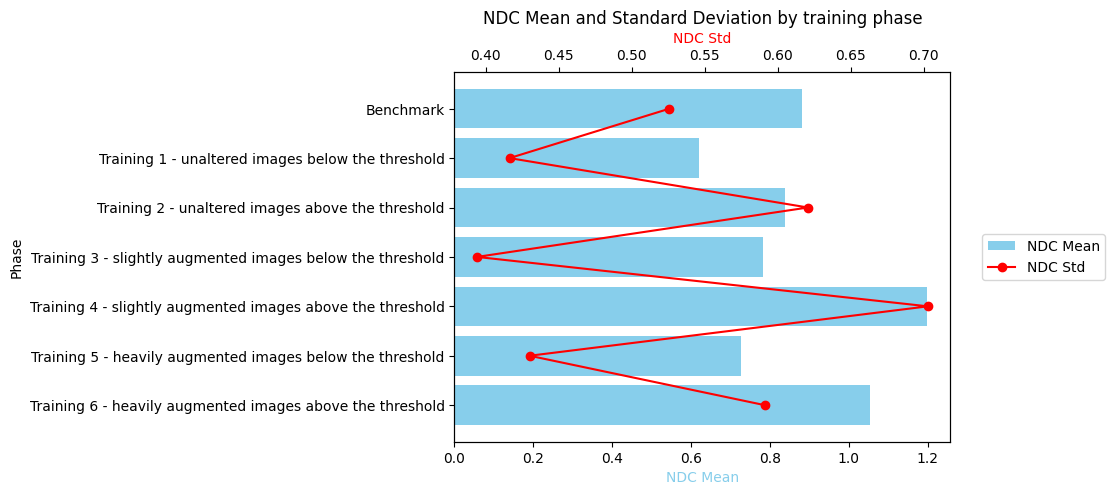

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the order of the phases
phase_order = ['Benchmark', 'T_OO', 'T_OB', 'T_LO', 'T_LB', 'T_ZO', 'T_ZB'][::-1]

# Mapping of phase names to desired display names
phase_name_mapping = {
    'Benchmark': 'Benchmark',
    'T_OO': 'Training 1 - unaltered images below the threshold',
    'T_OB': 'Training 2 - unaltered images above the threshold',
    'T_LO': 'Training 3 - slightly augmented images below the threshold',
    'T_LB': 'Training 4 - slightly augmented images above the threshold',
    'T_ZO': 'Training 5 - heavily augmented images below the threshold',
    'T_ZB': 'Training 6 - heavily augmented images above the threshold'
}

# Convert the 'Phase' column to a categorical type with the specified order
df_final['Phase'] = pd.Categorical(df_final['Phase'], categories=phase_order, ordered=True)

# Calculate mean, median, standard deviation, and variance per benchmark-string for NDC
NDC_statistics = df_final.groupby('Phase')['NDC'].agg(['mean', 'std']).reset_index()
NDC_statistics.columns = ['Phase', 'NDC Mean', 'NDC Std']

# Map the phase names to the desired display names
NDC_statistics['Phase'] = NDC_statistics['Phase'].map(phase_name_mapping)

# Plotting the histogram for NDC Mean
fig, ax1 = plt.subplots()

# Plot the NDC means as horizontal bars
bars = ax1.barh(NDC_statistics['Phase'], NDC_statistics['NDC Mean'], color='skyblue', label='NDC Mean')

# Plot the NDC standard deviations as a line
ax2 = ax1.twiny()
line, = ax2.plot(NDC_statistics['NDC Std'], NDC_statistics['Phase'], color='red', marker='o', linestyle='-', label='NDC Std')

# Adding labels and title
ax1.set_ylabel('Phase')
ax1.set_xlabel('NDC Mean', color='skyblue')
ax2.set_xlabel('NDC Std', color='red')
plt.title('NDC Mean and Standard Deviation by training phase')

# Adding legends and positioning them outside the plot area
ax1.legend(handles=[bars, line], loc='center left', bbox_to_anchor=(1.05, 0.5))

# Adjust layout to make room for the legends
fig.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()


In general, the graph shows that the average number of cars detected (NDC mean) increases as the training phase progresses. This suggests that the object detection model is getting better at detecting cars as it is trained with more data or with different data augmentation techniques.  it appears that training with heavily augmented images above the threshold (Training 6) might lead to the best performance in terms of NDC mean and standard deviation. This means that the model trained in this way detected the highest average number of cars and the number of cars detected was consistent across the images.
The lower standard deviation below the threshold indicates that the model's performance on IOU was more consistent across the training phases when trained on images below the threshold.

### 4.2.2 comparative statistics

In [56]:
from scipy.stats import ttest_rel

def comparative_statistics (phase1, phase2):
    iou_phase1 = df_final[df_final['Phase'] == phase1]['IOU']
    ndc_phase2 = df_final[df_final['Phase'] == phase1]['NDC']

    iou_phase2 = df_final[df_final['Phase'] == phase2]['IOU']
    ndc_phase2 = df_final[df_final['Phase'] == phase2]['NDC']
    
    # Perform paired t-test for IOU values across phases
    t_statistic_iou, p_value_iou = ttest_rel(iou_benchmark, iou_t_oo)

    # Perform paired t-test for NDC values across phases
    t_statistic_ndc, p_value_ndc = ttest_rel(ndc_benchmark, ndc_t_oo)


    # Print the results for IOU
    print("IOU Paired T-Test:")
    print("T Statistic:", t_statistic_iou)
    print("P-Value:", p_value_iou)

    # Print the results for NDC
    print("\nNDC Paired T-Test:")
    print("T Statistic:", t_statistic_ndc)
    print("P-Value:", p_value_ndc)

    # Interpret the results for IOU
    alpha = 0.05  # Significance level
    if p_value_iou < alpha:
        print("\nReject the null hypothesis for IOU. There is a significant difference in IOU values across phases.")
    else:
        print("\nFail to reject the null hypothesis for IOU. There is no significant difference in IOU values across phases.")

    # Interpret the results for NDC
    if p_value_ndc < alpha:
        print("Reject the null hypothesis for NDC. There is a significant difference in NDC values across phases.")
    else:
        print("Fail to reject the null hypothesis for NDC. There is no significant difference in NDC values across phases.")
    print("")

In [57]:
print("Paired T-Test for Benchmark & Training 1")
comparative_statistics("Benchmark","T_OO")
print("Paired T-Test for Training 1 & Training 2")
comparative_statistics("T_OO","T_OB")
print("Paired T-Test for Training 2 & Training 3")
comparative_statistics("T_OB","L_OO")
print("Paired T-Test for Training 3 & Training 4")
comparative_statistics("L_OO","L_OB")
print("Paired T-Test for Training 4 & Training 5")
comparative_statistics("L_OB","Z_OO")
print("Paired T-Test for Training 5 & Training 6")
comparative_statistics("Z_OO","Z_OB")

Paired T-Test for Benchmark & Training 1
IOU Paired T-Test:
T Statistic: 5.448111504261144
P-Value: 1.0503198408401472e-07

NDC Paired T-Test:
T Statistic: 8.962201168058995
P-Value: 3.254417029940541e-17

Reject the null hypothesis for IOU. There is a significant difference in IOU values across phases.
Reject the null hypothesis for NDC. There is a significant difference in NDC values across phases.

Paired T-Test for Training 1 & Training 2
IOU Paired T-Test:
T Statistic: 5.448111504261144
P-Value: 1.0503198408401472e-07

NDC Paired T-Test:
T Statistic: 8.962201168058995
P-Value: 3.254417029940541e-17

Reject the null hypothesis for IOU. There is a significant difference in IOU values across phases.
Reject the null hypothesis for NDC. There is a significant difference in NDC values across phases.

Paired T-Test for Training 2 & Training 3
IOU Paired T-Test:
T Statistic: 5.448111504261144
P-Value: 1.0503198408401472e-07

NDC Paired T-Test:
T Statistic: 8.962201168058995
P-Value: 3.254

### 4.2.3 correlation statistics

The correlation between IOU and NDC is: 0.6031375622649835


C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_20236\3702104124.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()
C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_20236\3702104124.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()


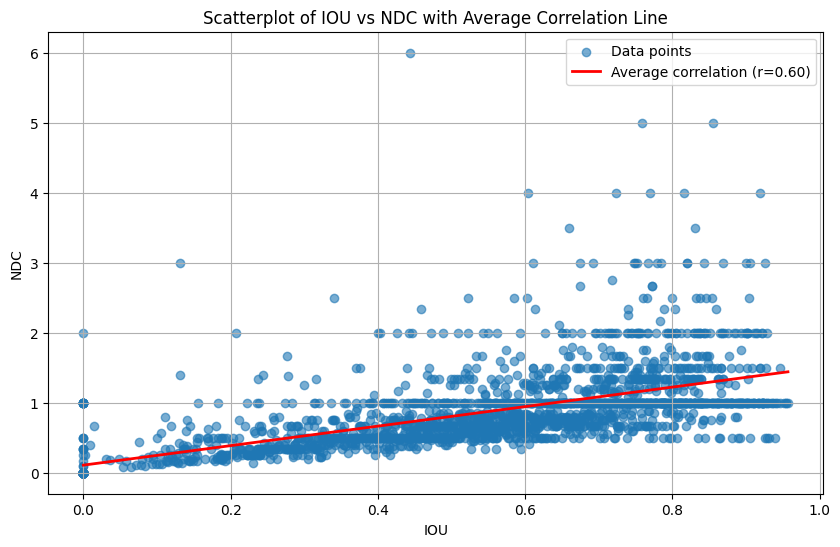

In [10]:
# Scatterplot for the correlation between IOU and NDC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Calculate the correlation between IOU and NDC
correlation = df_final['IOU'].corr(df_final['NDC'])
print(f'The correlation between IOU and NDC is: {correlation}')

# Calculate the correlation between IOU and NDC per phase
correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()
correlations.columns = ['Phase', 'Correlation IOU-NDC']

# Scatterplot for the correlation between IOU and NDC
plt.figure(figsize=(10, 6))
plt.scatter(df_final['IOU'], df_final['NDC'], alpha=0.6, label='Data points')

# Calculate the regression line
slope, intercept = np.polyfit(df_final['IOU'], df_final['NDC'], 1)
x = np.linspace(df_final['IOU'].min(), df_final['IOU'].max(), 100)
y = slope * x + intercept

# Plot the regression line
plt.plot(x, y, color='red', linewidth=2, label=f'Average correlation (r={correlation:.2f})')

# Adding title and labels
plt.title('Scatterplot of IOU vs NDC with Average Correlation Line')
plt.xlabel('IOU')
plt.ylabel('NDC')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Calculate the (Pearson) correlation between IOU and NDC
correlation = df_final['IOU'].corr(df_final['NDC'])

print(f'The correlation between IOU and NDC is: {correlation}')

# Calculate the correlation between IOU and NDC per phase
correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()
correlations.columns = ['Phase', 'Correlation IOU-NDC']

# Specify the order of the phases
phase_order = ['Benchmark', 'T_OO', 'T_OB', 'T_LO', 'T_LB', 'T_ZO', 'T_ZB']

# Print the correlations with phase names from the mapping, ordered by phase_order
for phase in phase_order:
    phase_display_name = phase_name_mapping.get(phase, phase)
    correlation = correlations[correlations['Phase'] == phase]['Correlation IOU-NDC'].values[0]
    print(f'The correlation between IOU and NDC for {phase_display_name} is: {correlation:.2f}')

The correlation between IOU and NDC is: 0.6031375622649835
The correlation between IOU and NDC for Benchmark is: 0.62
The correlation between IOU and NDC for Training 1 - unaltered images below the threshold is: 0.81
The correlation between IOU and NDC for Training 2 - unaltered images above the threshold is: 0.66
The correlation between IOU and NDC for Training 3 - slightly augmented images below the threshold is: 0.65
The correlation between IOU and NDC for Training 4 - slightly augmented images above the threshold is: 0.35
The correlation between IOU and NDC for Training 5 - heavily augmented images below the threshold is: 0.73
The correlation between IOU and NDC for Training 6 - heavily augmented images above the threshold is: 0.47


C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_18376\1157901170.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()
C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_18376\1157901170.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['IOU'].corr(x['NDC'])).reset_index()


In [ ]:
The correlation measure to use, will
depend on this shape (straight line - Pearson, curved line - Spearman).

C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_18376\1652239389.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['NDC'].corr(x['IOU']))
C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_18376\1652239389.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_final.groupby('Phase').apply(lambda x: x['NDC'].corr(x['IOU']))


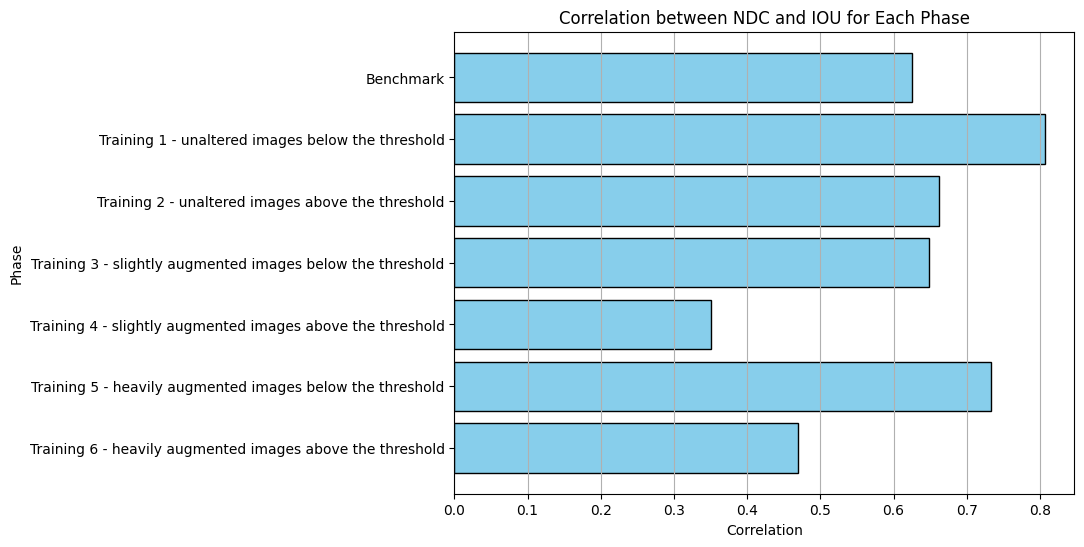

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the order of the phases
phase_order = ['Benchmark', 'T_OO', 'T_OB', 'T_LO', 'T_LB', 'T_ZO', 'T_ZB'][::-1]

# Mapping of phase names to desired display names
phase_name_mapping = {
    'Benchmark': 'Benchmark',
    'T_OO': 'Training 1 - unaltered images below the threshold',
    'T_OB': 'Training 2 - unaltered images above the threshold',
    'T_LO': 'Training 3 - slightly augmented images below the threshold',
    'T_LB': 'Training 4 - slightly augmented images above the threshold',
    'T_ZO': 'Training 5 - heavily augmented images below the threshold',
    'T_ZB': 'Training 6 - heavily augmented images above the threshold'
}

# Calculate the correlation between NDC and IOU per phase
correlations = df_final.groupby('Phase').apply(lambda x: x['NDC'].corr(x['IOU']))

# Plotting the bar plot with phase name mapping
plt.figure(figsize=(8, 6))
plt.barh([phase_name_mapping[phase] for phase in correlations.index], correlations.values, color='skyblue', edgecolor='black')
plt.xlabel('Correlation')
plt.ylabel('Phase')
plt.title('Correlation between NDC and IOU for Each Phase')
plt.grid(axis='x')
plt.show()